<a href="https://colab.research.google.com/github/aldo-arevalo/mimic-code/blob/master/notebooks/ICUglycemia/Notebooks/2_0_ara_pairing_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get relative characteristics(Nutrient intake，kidney function，liver function，ethnicity，gender，blood pressure) and make further filters


## Overview

This notebook contains the process for getting relative characteristics and further analysis.  
We imported the data in the MIMIC_IV database into the local PostgreSQL database, and we loaded the datafile __Pair_With_Time.csv__ extracted in __2_Match_glc_before_and_glc_after_and_join_with_age__ into new table __mimic_icu.glucose_insulin_ICU_2__ .
To run this program, please change the database connection settings.


# Code

## Import dependencies and libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as colors
from scipy import stats
from datetime import datetime
import time
import warnings
import psycopg2
# Below imports are used to print out pretty pandas dataframes
from IPython.display import display, HTML

conn = psycopg2.connect(database="mimiciv", user="postgres", password="mypassword", host="127.0.0.1", port="5432")

def convert_to_datetime(df,time_cols):
    for t_col in time_cols:
        df[t_col] = pd.to_datetime(df[t_col],utc=True)
    
    return(df)

D:\anaconda\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
D:\anaconda\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
D:\anaconda\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
D:\anaconda\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


In [2]:
# Get pair datas form Pair_With_Time.csv and make some analysis
origin_pair = pd.read_csv('./Data/Pair_With_Time.csv')

In [3]:

print("Total insulin injection event: {}".format(origin_pair[origin_pair['inputamount']>=0].shape[0]))
print("Of which:")
print("mathced glc_after: {}".format(origin_pair[origin_pair['glc_after']>=0].shape[0]))
print("mathced glc_before: {}".format(origin_pair[origin_pair['glc_before']>=0].shape[0]))
x=origin_pair[origin_pair['glc_before']>=0]
y=origin_pair[origin_pair['glc_after']>=0]
print("matched before and after: {}".format(x[x['glc_after']>=0].shape[0]))
print("matched before and after: {}".format(y[y['glc_before']>=0].shape[0]))


pair_with_before_after = x[x['glc_after']>=0]

print("\nIn all the injection events matched before and after：")
print("Entries:             {}".format(pair_with_before_after.shape[0]))
print("Patients:            {}".format(pair_with_before_after['subject_id'].nunique()))
bol_long_patients2 = pair_with_before_after['subject_id'].unique()
print("Hospital admissions: {}".format(pair_with_before_after ['hadm_id'].nunique()))
print('ICU stays:           {}'.format(pair_with_before_after ['stay_id'].nunique()))

Total insulin injection event: 234314
Of which:
mathced glc_after: 198047
mathced glc_before: 205913
matched before and after: 174280
matched before and after: 174280

In all the injection events matched before and after：
Entries:             174280
Patients:            22618
Hospital admissions: 26707
ICU stays:           28608


In [4]:
# weight analysis
display(HTML('<h5>Description of PATIENTWEIGHT</h5>'))

display(pair_with_before_after["patientweight"].describe())
print('Median: {}'.format(pair_with_before_after["patientweight"].median() ))
print('Mode: {}'.format(pair_with_before_after["patientweight"].mode()))

count    174280.000000
mean         87.426148
std          25.855980
min           1.000000
25%          70.000000
50%          84.000000
75%         100.000000
max        1120.000000
Name: patientweight, dtype: float64

Median: 84.0
Mode: 0    70.0
dtype: float64


In [6]:
weight70=pair_with_before_after[pair_with_before_after["patientweight"]==70]

No handles with labels found to put in legend.


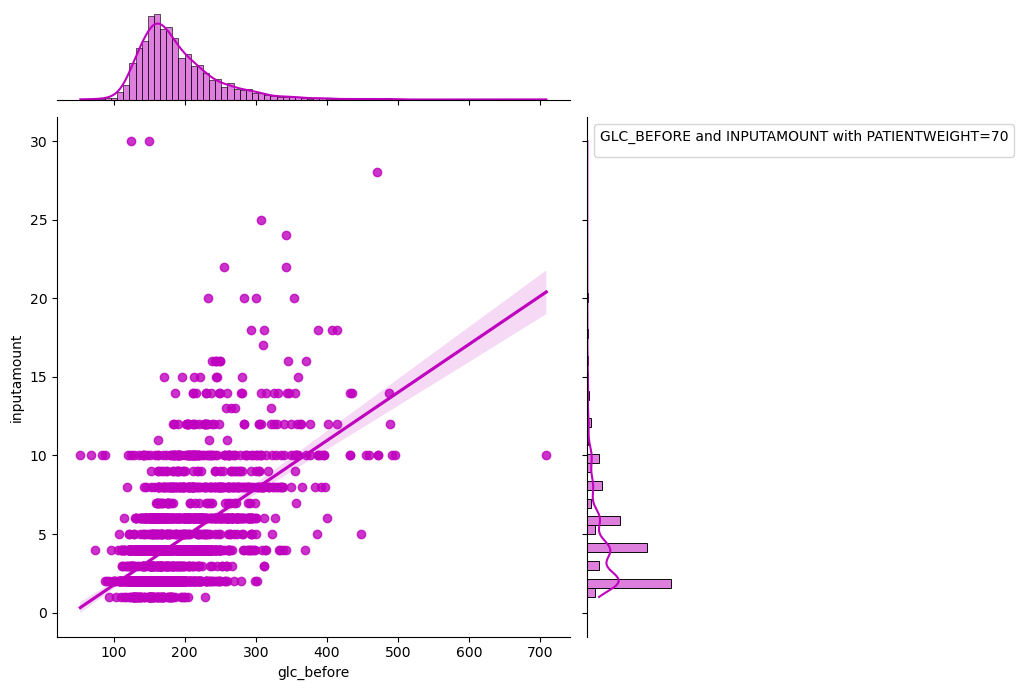

In [7]:
# JointPlot
sns.jointplot(x='glc_before', y='inputamount', data=weight70, kind='reg', color = 'm', height=7)
plt.xlabel('GLC_BEFORE (U/hr)', fontsize=18)
plt.ylabel('INPUTAMOUNT (U/hr)', fontsize = 18)

legend = plt.legend(title="GLC_BEFORE and INPUTAMOUNT with PATIENTWEIGHT=70")
legend._legend_box.align = "center"
ax = plt.gca()
ax.tick_params(labelsize = 16)
plt.show()

count    174280.000000
mean        195.873353
std          60.979947
min          12.000000
25%         155.000000
50%         181.000000
75%         224.000000
max         972.000000
Name: glc_before, dtype: float64

Median: 181.0
Mode: 0    154.0
dtype: float64


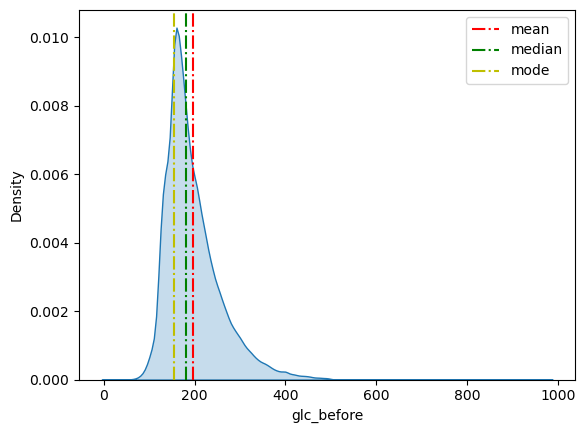

In [8]:
# glc_before analysis
display(HTML('<h5>Description of GLC_BEFORE</h5>'))
display(pair_with_before_after["glc_before"].describe())
print('Median: {}'.format(pair_with_before_after["glc_before"].median() ))
print('Mode: {}'.format(pair_with_before_after["glc_before"].mode()))
sns.kdeplot(pair_with_before_after["glc_before"], shade=True)   # 给出 s 的概率密度曲线
plt.axvline(pair_with_before_after["glc_before"].mean(), label='mean',linestyle='-.', color='r')
plt.axvline(pair_with_before_after["glc_before"].median(), label='median',linestyle='-.', color='g')
plt.axvline(154, label='mode',linestyle='-.', color='y')

plt.legend()
plt.show()

No handles with labels found to put in legend.


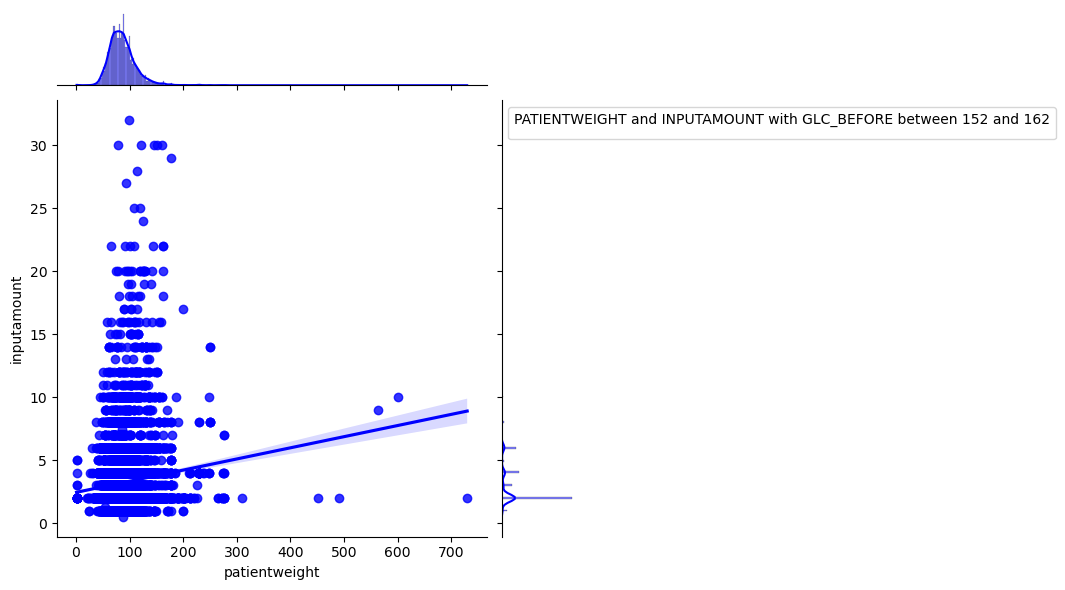

In [9]:
glcbefore162=pair_with_before_after[pair_with_before_after["glc_before"]<=162]
glcbefore152162=glcbefore162[glcbefore162["glc_before"]>=152]

# JointPlot
sns.jointplot(x='patientweight', y='inputamount', data=glcbefore152162, kind='reg', color = 'b', height=6)
plt.xlabel('PATIENTWEIGHT (kg)', fontsize=18)
plt.ylabel('INPUTAMOUNT (U)', fontsize = 18)

legend = plt.legend(title="PATIENTWEIGHT and INPUTAMOUNT with GLC_BEFORE between 152 and 162")
legend._legend_box.align = "center"
ax = plt.gca()
ax.tick_params(labelsize = 16)
plt.show()

In [10]:
pair_with_before_after[pair_with_before_after["patientweight"]<=20].shape[0]

95

No handles with labels found to put in legend.


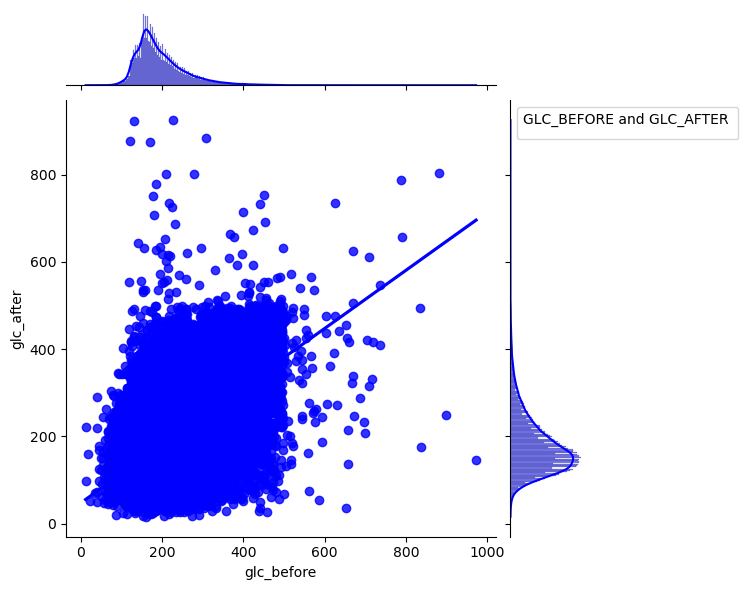

In [11]:
# analysis between glc_before and glc_after
sns.jointplot(x='glc_before', y='glc_after', data=pair_with_before_after, kind='reg', color = 'b', height=6)
plt.xlabel('GLC_BEFORE (mg/dl)', fontsize=18)
plt.ylabel('GLC_AFTER (mg/ml)', fontsize = 18)

legend = plt.legend(title="GLC_BEFORE and GLC_AFTER ")
legend._legend_box.align = "center"
ax = plt.gca()
ax.tick_params(labelsize = 16)
plt.show()

No handles with labels found to put in legend.


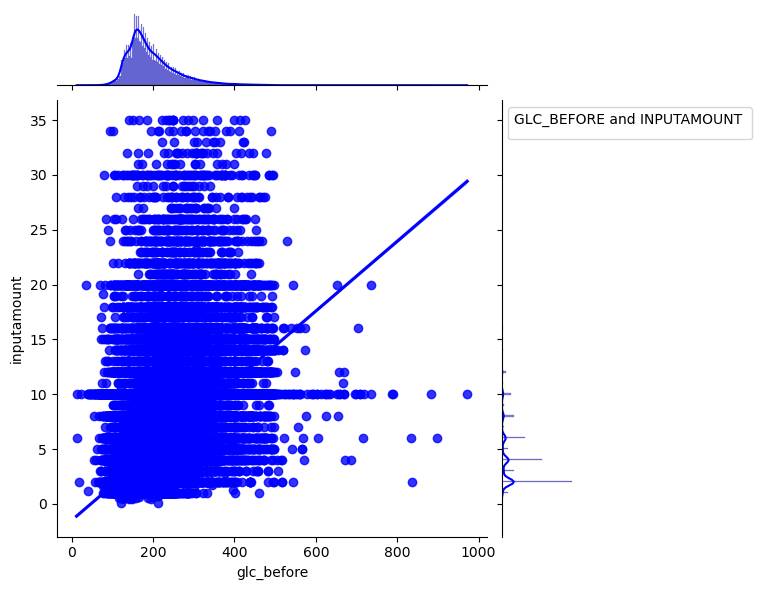

In [12]:
# analysis between glc_before and inputamount
sns.jointplot(x='glc_before', y='inputamount', data=pair_with_before_after, kind='reg', color = 'b', height=6)
plt.xlabel('GLC_BEFORE (mg/dl)', fontsize=18)
plt.ylabel('INPUTAMOUNT (U)', fontsize = 18)

legend = plt.legend(title="GLC_BEFORE and INPUTAMOUNT ")
legend._legend_box.align = "center"
ax = plt.gca()
ax.tick_params(labelsize = 16)
plt.show()

No handles with labels found to put in legend.


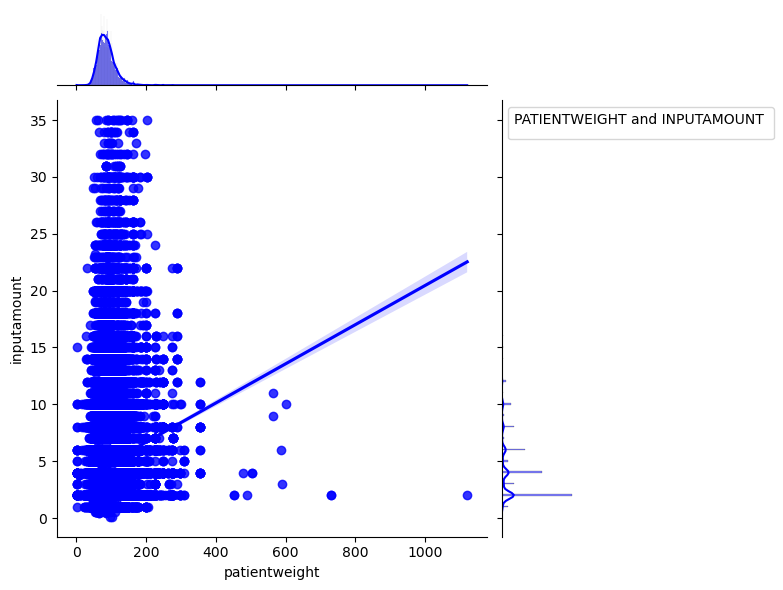

In [13]:
# analysis between patientweight and inputamount
sns.jointplot(x='patientweight', y='inputamount', data=pair_with_before_after, kind='reg', color = 'b', height=6)
plt.xlabel('PATIENTWEIGHT (kg)', fontsize=18)
plt.ylabel('INPUTAMOUNT (U)', fontsize = 18)

legend = plt.legend(title="PATIENTWEIGHT and INPUTAMOUNT ")
legend._legend_box.align = "center"
ax = plt.gca()
ax.tick_params(labelsize = 16)
plt.show()

In [14]:

# Normality test
# 
u1,u2,u3 = pair_with_before_after['inputamount'].mean(),pair_with_before_after['glc_before'].mean(),pair_with_before_after['patientweight'].mean()  # 计算均值
std1,std2,std3 = pair_with_before_after['inputamount'].std(), pair_with_before_after['glc_before'].std(), pair_with_before_after['patientweight'].std()  # 计算标准差
print('Normality test for INPUTAMOUNT：\n',stats.kstest(pair_with_before_after['inputamount'], 'norm', (u1, std1)))
print('Normality test for GLC_BEFORE：\n',stats.kstest(pair_with_before_after['glc_before'], 'norm', (u2, std2)))
print('Normality test for PATIENTWEIGHT：\n',stats.kstest(pair_with_before_after['patientweight'], 'norm', (u3, std3)))


# pearson correlation coefficient
print('\npearson correlation coefficient between "INPUTAMOUNT" and "GLC_BEFORE":',pair_with_before_after["inputamount"].corr(pair_with_before_after["glc_before"]))

# 计算"INPUTAMOUNT"与"PATIENTWEIGHT"之间的pearson相关系数
print('\npearson correlation coefficient between "INPUTAMOUNT" and "PATIENTWEIGHT":',pair_with_before_after["inputamount"].corr(pair_with_before_after["patientweight"]))

#Spearman相关系数，又称秩相关系数，不要求正态分布
print('\npearson correlation coefficient between "INPUTAMOUNT"and  "GLC_BEFORE":',pair_with_before_after["inputamount"].corr(pair_with_before_after["glc_before"],method='spearman'))

print('\npearson correlation coefficient between "INPUTAMOUNT" and "PATIENTWEIGHT":',pair_with_before_after["inputamount"].corr(pair_with_before_after["patientweight"],method='spearman'))

#kendall相关系数，也是一种秩相关系数，将数据按某列排序，其他列数据通常是乱序的。它所计算的对象是分类变量。

Normality test for INPUTAMOUNT：
 KstestResult(statistic=0.22669095778323545, pvalue=0.0)
Normality test for GLC_BEFORE：
 KstestResult(statistic=0.10920102440281948, pvalue=0.0)
Normality test for PATIENTWEIGHT：
 KstestResult(statistic=0.07461081558974159, pvalue=0.0)

pearson correlation coefficient between "INPUTAMOUNT" and "GLC_BEFORE": 0.5307111989180973

pearson correlation coefficient between "INPUTAMOUNT" and "PATIENTWEIGHT": 0.12199473014079007

pearson correlation coefficient between "INPUTAMOUNT"and  "GLC_BEFORE": 0.5334743593578116

pearson correlation coefficient between "INPUTAMOUNT" and "PATIENTWEIGHT": 0.09766882739771976


# Merge with nutrient intake events , get nutrisonid
We imported the data in the MIMIC_IV database into the local PostgreSQL database, and we loaded the datafile Pair_With_Time.csv extracted in 2_0_Match_glc_before_and_glc_after_and_join_with_age into new table mimic_icu.glucose_insulin_ICU_2 .

In [21]:
conn = psycopg2.connect(database="mimiciv", user="postgres", password="mypassword", host="127.0.0.1", port="5432",options="-c search_path=mimic_icu")

#  nutrient intake
sql = """select glucose_insulin_icu_2.*,inputevents.itemid as nutrisonid
from glucose_insulin_icu_2 left join inputevents 
on glucose_insulin_icu_2.subject_id = inputevents.subject_id 
and glucose_insulin_icu_2.inputamount>=0
and inputevents.itemid in (select itemid from mimic_icu.d_items where lower(d_items.category) like '%nutrition%')
and (inputevents.starttime between glucose_insulin_icu_2.TIMER_BEFORE and glucose_insulin_icu_2.TIMER_AFTER 
or inputevents.endtime between glucose_insulin_icu_2.TIMER_BEFORE and glucose_insulin_icu_2.TIMER_AFTER)  order by SUBJECT_ID, HADM_ID, STAY_ID,timer;"""
WITH_NUTRISON = pd.read_sql(sql, conn)

In [22]:
WITH_NUTRISON.head(10)

,subject_id,hadm_id,stay_id,icu_admissiontime,icu_dischargetime,los_icu_days,timer,starttime,glctimer,endtime,...,chart_store,timediff_before,timediff_after,glc_before,clause_before,timer_before,anchor_age,glc_after,timer_after,nutrisonid
0,10002013,23581541,39060235,2160-05-18 10:00:53,2160-05-19 17:33:33,1.314352,2160-05-18 10:26:00,NaT,2160-05-18 10:26:00,NaT,...,0.0,NaN,NaN,NaN,NaN,NaT,53,NaN,NaT,NaN
1,10002013,23581541,39060235,2160-05-18 10:00:53,2160-05-19 17:33:33,1.314352,2160-05-18 11:23:00,NaT,2160-05-18 11:23:00,NaT,...,0.0,NaN,NaN,NaN,NaN,NaT,53,NaN,NaT,NaN
2,10002013,23581541,39060235,2160-05-18 10:00:53,2160-05-19 17:33:33,1.314352,2160-05-18 12:20:00,NaT,2160-05-18 12:20:00,NaT,...,0.0,NaN,NaN,NaN,NaN,NaT,53,NaN,NaT,NaN
3,10002013,23581541,39060235,2160-05-18 10:00:53,2160-05-19 17:33:33,1.314352,2160-05-18 13:02:00,NaT,2160-05-18 13:02:00,NaT,...,0.0,NaN,NaN,NaN,NaN,NaT,53,NaN,NaT,NaN
4,10002013,23581541,39060235,2160-05-18 10:00:53,2160-05-19 17:33:33,1.314352,2160-05-18 14:46:00,NaT,2160-05-18 14:46:00,NaT,...,0.0,NaN,NaN,NaN,NaN,NaT,53,NaN,NaT,NaN
5,10002013,23581541,39060235,2160-05-18 10:00:53,2160-05-19 17:33:33,1.314352,2160-05-18 15:01:00,2160-05-18 15:00:00,NaT,2160-05-18 15:01:00,...,NaN,15.0,62.0,154.0,2.0,2160-05-18 14:46:00,53,155.0,2160-05-18 16:03:00,NaN
6,10002013,23581541,39060235,2160-05-18 10:00:53,2160-05-19 17:33:33,1.314352,2160-05-18 16:03:00,NaT,2160-05-18 16:03:00,NaT,...,0.0,NaN,NaN,NaN,NaN,NaT,53,NaN,NaT,NaN
7,10002013,23581541,39060235,2160-05-18 10:00:53,2160-05-19 17:33:33,1.314352,2160-05-18 16:16:00,2160-05-18 16:15:00,NaT,2160-05-18 16:16:00,...,NaN,13.0,44.0,155.0,2.0,2160-05-18 16:03:00,53,154.0,2160-05-18 17:00:00,NaN
8,10002013,23581541,39060235,2160-05-18 10:00:53,2160-05-19 17:33:33,1.314352,2160-05-18 17:00:00,NaT,2160-05-18 17:00:00,NaT,...,0.0,NaN,NaN,NaN,NaN,NaT,53,NaN,NaT,NaN
9,10002013,23581541,39060235,2160-05-18 10:00:53,2160-05-19 17:33:33,1.314352,2160-05-18 17:01:00,2160-05-18 17:00:00,NaT,2160-05-18 17:01:00,...,NaN,1.0,41.0,154.0,2.0,2160-05-18 17:00:00,53,179.0,2160-05-18 18:51:00,NaN


In [23]:
WITH_NUTRISON.shape[0]

1357980

In [24]:
#drop the same records that has multiple injections of the same nutrient solution
WITH_NUTRISON.drop_duplicates(keep='first',inplace=True)

In [25]:
WITH_NUTRISON.shape[0]

1323360

In [26]:
# Screened out the types of nutrient solutions that were injected more than 500 times
nutrison_list = []
for key, value in WITH_NUTRISON.nutrisonid.value_counts().items():
    if value>=500:
        nutrison_list.append(key)

In [27]:
WITH_NUTRISON.nutrisonid.value_counts()

225936.0    4211
228351.0    3581
229295.0    3124
229013.0    3053
229296.0    2325
            ... 
226036.0       1
228133.0       1
228360.0       1
227699.0       1
227090.0       1
Name: nutrisonid, Length: 83, dtype: int64

In [28]:
nutrison_list

[225936.0,
 228351.0,
 229295.0,
 229013.0,
 229296.0,
 225970.0,
 225916.0,
 229297.0,
 226880.0,
 229011.0,
 227975.0,
 229009.0,
 229014.0,
 227695.0,
 225917.0,
 228135.0,
 227979.0,
 225931.0,
 228367.0,
 225948.0,
 229010.0,
 225947.0,
 228363.0,
 225935.0,
 229012.0,
 228383.0,
 221036.0,
 228359.0]

In [30]:
# find  nutrison items only in nutrison_list
sql = """select glucose_insulin_icu_2.*,inputevents.itemid as nutrisonid
from glucose_insulin_icu_2 left join inputevents 
on glucose_insulin_icu_2.subject_id = inputevents.subject_id 
and glucose_insulin_icu_2.inputamount>=0
and inputevents.itemid in (225936,228351,229295,229013,229296,225970,225916,229297,226880,229011,227975,229009,229014,227695,225917,228135,227979,225931,228367,225948,229010,225947,228363,225935,229012,228383,221036,228359)
and (inputevents.starttime between glucose_insulin_icu_2.TIMER_BEFORE and glucose_insulin_icu_2.TIMER_AFTER 
or inputevents.endtime between glucose_insulin_icu_2.TIMER_BEFORE and glucose_insulin_icu_2.TIMER_AFTER)  order by SUBJECT_ID, HADM_ID, STAY_ID,timer;"""
WITH_NUTRISON500 = pd.read_sql(sql, conn)

In [35]:
WITH_NUTRISON500.head(10)

,subject_id,hadm_id,stay_id,icu_admissiontime,icu_dischargetime,los_icu_days,timer,starttime,glctimer,endtime,...,chart_store,timediff_before,timediff_after,glc_before,clause_before,timer_before,anchor_age,glc_after,timer_after,nutrisonid
0,10002013,23581541,39060235,2160-05-18 10:00:53,2160-05-19 17:33:33,1.314352,2160-05-18 10:26:00,NaT,2160-05-18 10:26:00,NaT,...,0.0,NaN,NaN,NaN,NaN,NaT,53,NaN,NaT,NaN
1,10002013,23581541,39060235,2160-05-18 10:00:53,2160-05-19 17:33:33,1.314352,2160-05-18 11:23:00,NaT,2160-05-18 11:23:00,NaT,...,0.0,NaN,NaN,NaN,NaN,NaT,53,NaN,NaT,NaN
2,10002013,23581541,39060235,2160-05-18 10:00:53,2160-05-19 17:33:33,1.314352,2160-05-18 12:20:00,NaT,2160-05-18 12:20:00,NaT,...,0.0,NaN,NaN,NaN,NaN,NaT,53,NaN,NaT,NaN
3,10002013,23581541,39060235,2160-05-18 10:00:53,2160-05-19 17:33:33,1.314352,2160-05-18 13:02:00,NaT,2160-05-18 13:02:00,NaT,...,0.0,NaN,NaN,NaN,NaN,NaT,53,NaN,NaT,NaN
4,10002013,23581541,39060235,2160-05-18 10:00:53,2160-05-19 17:33:33,1.314352,2160-05-18 14:46:00,NaT,2160-05-18 14:46:00,NaT,...,0.0,NaN,NaN,NaN,NaN,NaT,53,NaN,NaT,NaN
5,10002013,23581541,39060235,2160-05-18 10:00:53,2160-05-19 17:33:33,1.314352,2160-05-18 15:01:00,2160-05-18 15:00:00,NaT,2160-05-18 15:01:00,...,NaN,15.0,62.0,154.0,2.0,2160-05-18 14:46:00,53,155.0,2160-05-18 16:03:00,NaN
6,10002013,23581541,39060235,2160-05-18 10:00:53,2160-05-19 17:33:33,1.314352,2160-05-18 16:03:00,NaT,2160-05-18 16:03:00,NaT,...,0.0,NaN,NaN,NaN,NaN,NaT,53,NaN,NaT,NaN
7,10002013,23581541,39060235,2160-05-18 10:00:53,2160-05-19 17:33:33,1.314352,2160-05-18 16:16:00,2160-05-18 16:15:00,NaT,2160-05-18 16:16:00,...,NaN,13.0,44.0,155.0,2.0,2160-05-18 16:03:00,53,154.0,2160-05-18 17:00:00,NaN
8,10002013,23581541,39060235,2160-05-18 10:00:53,2160-05-19 17:33:33,1.314352,2160-05-18 17:00:00,NaT,2160-05-18 17:00:00,NaT,...,0.0,NaN,NaN,NaN,NaN,NaT,53,NaN,NaT,NaN
9,10002013,23581541,39060235,2160-05-18 10:00:53,2160-05-19 17:33:33,1.314352,2160-05-18 17:01:00,2160-05-18 17:00:00,NaT,2160-05-18 17:01:00,...,NaN,1.0,41.0,154.0,2.0,2160-05-18 17:00:00,53,149.0,2160-05-18 17:42:00,NaN


In [31]:
WITH_NUTRISON500.shape[0]

1355224

In [32]:
WITH_NUTRISON500.drop_duplicates(keep='first',inplace=True)

In [33]:
WITH_NUTRISON500.shape[0]

1322353

In [35]:
WITH_NUTRISON500.nutrisonid.value_counts()

225936.0    4211
228351.0    3581
229295.0    3124
229013.0    3053
229296.0    2325
225970.0    2106
225916.0    1534
229297.0    1451
226880.0    1350
229011.0    1341
227975.0    1328
229009.0    1276
229014.0    1203
227695.0    1121
225917.0    1046
228135.0     997
227979.0     976
225931.0     902
228367.0     895
225948.0     865
229010.0     816
225947.0     773
228363.0     648
225935.0     609
229012.0     597
228383.0     570
221036.0     508
228359.0     500
Name: nutrisonid, dtype: int64

In [36]:
WITH_NUTRISON500[WITH_NUTRISON500["nutrisonid"]>0].shape[0]

39706

In [37]:
WITH_NUTRISON500[WITH_NUTRISON500["inputamount"]>0].shape[0]

239343

In [38]:
WITH_NUTRISON500[WITH_NUTRISON500["nutrisonid"]>0].shape[0]/WITH_NUTRISON500[WITH_NUTRISON500["inputamount"]>0].shape[0]

0.16589580643678736

In [39]:
# glc_before < glc_after with  nutrient intake
WITH_NUTRISON500[WITH_NUTRISON500["nutrisonid"]>0][WITH_NUTRISON500["glc_before"]<WITH_NUTRISON500["glc_after"]].shape[0]

<ipython-input-39-1e34bd61518b>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  WITH_NUTRISON500[WITH_NUTRISON500["nutrisonid"]>0][WITH_NUTRISON500["glc_before"]<WITH_NUTRISON500["glc_after"]].shape[0]


14108

In [40]:
WITH_NUTRISON500[WITH_NUTRISON500["glc_before"]<WITH_NUTRISON500["glc_after"]].shape[0]

61077

In [41]:
WITH_NUTRISON500.shape[0]

1322353

In [42]:
WITH_NUTRISON500.to_csv('./Data/Pair_With_Nutrison.csv', index=False,encoding='utf8', header = True)

##### We loaded the datafile Pair_With_Nutrison into new table mimic_icu.glucose_insulin_ICU_3

In [44]:
### select from table glucose_insulin_ICU_3 with new characteristic 'hasnutrison'
sql = """select glucose_insulin_icu_3.*, 
      (CASE
        WHEN glucose_insulin_icu_3.nutrisonid>0 
        THEN 1
        ELSE null END
    ) AS hasnutrison
from glucose_insulin_icu_3 order by SUBJECT_ID, HADM_ID, STAY_ID,timer;"""
WITH_HASNUTRISON = pd.read_sql(sql, conn)

In [45]:
WITH_HASNUTRISON.shape[0]

1322353

In [46]:
WITH_HASNUTRISON[WITH_HASNUTRISON['nutrisonid']>0].head()

,subject_id,hadm_id,stay_id,icu_admissiontime,icu_dischargetime,los_icu_days,timer,starttime,glctimer,endtime,...,timediff_before,timediff_after,glc_before,clause_before,timer_before,anchor_age,glc_after,timer_after,nutrisonid,hasnutrison
346,10004401,29988601,32773003,2144-01-26 22:28:04,2144-02-06 13:44:15,10.636238,2144-01-28 14:27:00,2144-01-28 14:26:00,NaT,2144-01-28 14:27:00,...,27.0,333.0,122.0,2.0,2144-01-28 14:00:00,82,140.0,2144-01-28 20:00:00,227975.0,1.0
351,10004401,29988601,32773003,2144-01-26 22:28:04,2144-02-06 13:44:15,10.636238,2144-01-29 08:01:00,2144-01-29 08:00:00,NaT,2144-01-29 08:01:00,...,1.0,359.0,139.0,2.0,2144-01-29 08:00:00,82,127.0,2144-01-29 14:00:00,227975.0,1.0
356,10004401,29988601,32773003,2144-01-26 22:28:04,2144-02-06 13:44:15,10.636238,2144-01-30 08:21:00,2144-01-30 08:20:00,NaT,2144-01-30 08:21:00,...,21.0,339.0,131.0,2.0,2144-01-30 08:00:00,82,115.0,2144-01-30 14:00:00,225970.0,1.0
357,10004401,29988601,32773003,2144-01-26 22:28:04,2144-02-06 13:44:15,10.636238,2144-01-30 08:21:00,2144-01-30 08:20:00,NaT,2144-01-30 08:21:00,...,21.0,339.0,131.0,2.0,2144-01-30 08:00:00,82,115.0,2144-01-30 14:00:00,227975.0,1.0
360,10004401,29988601,32773003,2144-01-26 22:28:04,2144-02-06 13:44:15,10.636238,2144-01-30 21:16:00,2144-01-30 21:15:00,NaT,2144-01-30 21:16:00,...,16.0,284.0,199.0,2.0,2144-01-30 21:00:00,82,171.0,2144-01-31 02:00:00,225970.0,1.0


In [47]:
WITH_HASNUTRISON = WITH_HASNUTRISON.drop(['nutrisonid'], axis=1)

In [48]:
WITH_HASNUTRISON.drop_duplicates(keep='first',inplace=True)

In [49]:
WITH_HASNUTRISON.shape[0]

1317324

In [50]:
WITH_HASNUTRISON.to_csv('./Data/Pair_With_hasNutrison.csv', index=False,encoding='utf8', header = True)

# Add characteristic gender and ethnicity
We loaded the datafile Pair_With_hasNutrison.csv into new table mimic_icu.pair_1

In [52]:
# join with table mimic_core.admissions and mimic_core.patients ,to get ethnicity and gender

sql = """select mimic_icu.pair_1.*
 ,(CASE   
        WHEN mimic_core.admissions.ethnicity in('OTHER','UNKNOWN','UNABLE TO OBTAIN')
        THEN 'UNKNOWN'
        ELSE mimic_core.admissions.ethnicity
        END) as ethnicity,
mimic_core.patients.gender
from  (mimic_icu.pair_1 left join mimic_core.admissions 
on 
mimic_icu.pair_1.subject_id = mimic_core.admissions.subject_id and 
mimic_icu.pair_1.hadm_id = mimic_core.admissions.hadm_id )
left join mimic_core.patients 
on
mimic_icu.pair_1.subject_id=mimic_core.patients.subject_id
"""
#conn = psycopg2.connect(database="mimiciv", user="postgres", password="mypassword", host="127.0.0.1", port="5432",options="-c search_path=mimic_core")
WITH_ETHNICITY = pd.read_sql(sql, conn)

In [53]:
PAIR_WITH_ETHNICITY=WITH_ETHNICITY[WITH_ETHNICITY["glc_before"]>0]
PAIR_WITH_ETHNICITY=PAIR_WITH_ETHNICITY[PAIR_WITH_ETHNICITY["glc_after"]>0]
PAIR_WITH_ETHNICITY.shape[0]

174280

In [54]:
PAIR_WITH_ETHNICITY[WITH_ETHNICITY["inputamount"]>0].ethnicity.value_counts()

<ipython-input-54-257626449b64>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  PAIR_WITH_ETHNICITY[WITH_ETHNICITY["inputamount"]>0].ethnicity.value_counts()


WHITE                            114114
UNKNOWN                           29205
BLACK/AFRICAN AMERICAN            18224
HISPANIC/LATINO                    7142
ASIAN                              5157
AMERICAN INDIAN/ALASKA NATIVE       438
Name: ethnicity, dtype: int64

In [55]:
PAIR_WITH_ETHNICITY[WITH_ETHNICITY["inputamount"]>0].shape[0]

<ipython-input-55-4e28c9608077>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  PAIR_WITH_ETHNICITY[WITH_ETHNICITY["inputamount"]>0].shape[0]


174280

In [56]:
WITH_ETHNICITY.shape[0]

1317324

In [57]:
WITH_ETHNICITY.to_csv('./Data/Pair_With_GENDER_ETHNICITY.csv', index=False,encoding='utf8', header = True)

In [58]:
WITH_ETHNICITY.head()

,subject_id,hadm_id,stay_id,icu_admissiontime,icu_dischargetime,los_icu_days,timer,starttime,glctimer,endtime,...,timediff_after,glc_before,clause_before,timer_before,anchor_age,glc_after,timer_after,hasnutrison,ethnicity,gender
0,10013643,22009484,33072499,2200-10-01 08:42:08,2200-10-05 18:16:16,4.398704,2200-10-01 18:00:00,NaT,2200-10-01 18:00:00,NaT,...,NaN,NaN,NaN,NaT,79,NaN,NaT,NaN,WHITE,F
1,10013643,22009484,33072499,2200-10-01 08:42:08,2200-10-05 18:16:16,4.398704,2200-10-01 20:12:00,NaT,2200-10-01 20:12:00,NaT,...,NaN,NaN,NaN,NaT,79,NaN,NaT,NaN,WHITE,F
2,10013643,22009484,33072499,2200-10-01 08:42:08,2200-10-05 18:16:16,4.398704,2200-10-01 20:46:00,2200-10-01 20:45:00,NaT,2200-10-01 20:46:00,...,194.0,158.0,2.0,2200-10-01 20:12:00,79,168.0,2200-10-02 00:00:00,NaN,WHITE,F
3,10013643,22009484,33072499,2200-10-01 08:42:08,2200-10-05 18:16:16,4.398704,2200-10-02 00:00:00,NaT,2200-10-02 00:00:00,NaT,...,NaN,NaN,NaN,NaT,79,NaN,NaT,NaN,WHITE,F
4,10013643,22009484,33072499,2200-10-01 08:42:08,2200-10-05 18:16:16,4.398704,2200-10-02 00:12:00,2200-10-02 00:11:00,NaT,2200-10-02 00:12:00,...,228.0,168.0,2.0,2200-10-02 00:00:00,79,189.0,2200-10-02 04:00:00,NaN,WHITE,F


In [60]:
conn.close()

# SOFA score,creatinine,blood urea nitrogen,liver function
We reloaded the datafile Pair_With_GENDER_ETHNICITY into table mimic_icu.pair_1.\
We calculate the SOFA score based on the tutorial from mimiciv database to calculate SOFA.\
And we loaded the SOFA score,creatinine,blood urea nitrogen,bilirubin, bilirubin_direct,bilirubin_indirect,alt and ast into new table  mimic_derived.sofa.

In [61]:
sql = """select mimic_icu.pair_1.*,mimic_derived.sofa.sofa_24hours as sofa,
creatinine_24hours as creatinine,bun_24hours as bun,
bilirubin_24hours as bilirubin, bilirubin_direct_24hours as bilirubin_direct,
bilirubin_indirect_24hours as bilirubin_indirect,
alt_24hours as alt, ast_24hours as ast
from  mimic_icu.pair_1 left join mimic_derived.sofa
on 
(mimic_icu.pair_1.inputamount>=0 and
mimic_icu.pair_1.stay_id = mimic_derived.sofa.stay_id and 
mimic_icu.pair_1.timer between  mimic_derived.sofa.starttime and (mimic_derived.sofa.endtime - INTERVAL '1 minute'))
order by   SUBJECT_ID, HADM_ID, STAY_ID,timer;
"""
conn = psycopg2.connect(database="mimiciv", user="postgres", password="mypassword", host="127.0.0.1", port="5432")
WITH_SOFA = pd.read_sql(sql, conn)

In [62]:
WITH_SOFA.shape[0]

1317324

In [63]:
WITH_SOFA.drop_duplicates(keep='first',inplace=True)
WITH_SOFA.shape[0]

1317324

In [64]:
PAIR_WITH_SOFA=WITH_SOFA[WITH_SOFA["glc_before"]>0]
PAIR_WITH_SOFA=PAIR_WITH_SOFA[PAIR_WITH_SOFA["glc_after"]>0]

In [65]:
PAIR_WITH_SOFA.shape[0]

174280

In [66]:
PAIR_WITH_SOFA[PAIR_WITH_SOFA['creatinine']>0].shape[0]

171214

In [67]:
PAIR_WITH_SOFA[PAIR_WITH_SOFA['creatinine']>0].creatinine.describe()

count    171214.000000
mean          1.633578
std           1.482107
min           0.100000
25%           0.800000
50%           1.100000
75%           1.900000
max          23.900000
Name: creatinine, dtype: float64

In [68]:
PAIR_WITH_SOFA[PAIR_WITH_SOFA['bun']>0].shape[0]

171212

In [69]:
PAIR_WITH_SOFA[PAIR_WITH_SOFA['bun']>0].bun.describe()

count    171212.000000
mean         36.135540
std          27.509976
min           1.000000
25%          17.000000
50%          27.000000
75%          47.000000
max         290.000000
Name: bun, dtype: float64

In [70]:
PAIR_WITH_SOFA[PAIR_WITH_SOFA['creatinine']>0][PAIR_WITH_SOFA['bun']>0].shape[0]


<ipython-input-70-eaabc659584e>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  PAIR_WITH_SOFA[PAIR_WITH_SOFA['creatinine']>0][PAIR_WITH_SOFA['bun']>0].shape[0]


171128

In [71]:
PAIR_WITH_SOFA[PAIR_WITH_SOFA['bun']>0][PAIR_WITH_SOFA['creatinine']>0].shape[0]

<ipython-input-71-31a62883605b>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  PAIR_WITH_SOFA[PAIR_WITH_SOFA['bun']>0][PAIR_WITH_SOFA['creatinine']>0].shape[0]


171128

In [72]:
print('\nPearson correlation coefficient between "creatinine" and "glc_after":',PAIR_WITH_SOFA["creatinine"].corr(PAIR_WITH_SOFA["glc_after"]))

print('\nSpearman correlation coefficient between "creatinine" and "glc_after":',PAIR_WITH_SOFA["creatinine"].corr(PAIR_WITH_SOFA["glc_after"],method='spearman'))

print('\nPearson correlation coefficient between "bun" and "glc_after":',PAIR_WITH_SOFA["bun"].corr(PAIR_WITH_SOFA["glc_after"]))

print('\nPearson correlation coefficient between "creatinine" and inputamount":',PAIR_WITH_SOFA["creatinine"].corr(PAIR_WITH_SOFA["inputamount"]))

print('\nSpearman correlation coefficient between "creatinine" and "inputamount":',PAIR_WITH_SOFA["creatinine"].corr(PAIR_WITH_SOFA["inputamount"],method='spearman'))

print('\nSpearman correlation coefficient between "bun" and "inputamount":',PAIR_WITH_SOFA["bun"].corr(PAIR_WITH_SOFA["inputamount"]))




Pearson correlation coefficient between "creatinine" and "glc_after": 0.09448033158335746

Spearman correlation coefficient between "creatinine" and "glc_after": 0.11336922820024808

Pearson correlation coefficient between "bun" and "glc_after": 0.1449191387246048

Pearson correlation coefficient between "creatinine" and inputamount": 0.07317053554155616

Spearman correlation coefficient between "creatinine" and "inputamount": 0.099714326530254

Spearman correlation coefficient between "bun" and "inputamount": 0.1246425090167997


In [73]:
PAIR_WITH_SOFA[PAIR_WITH_SOFA['bilirubin']>0].shape[0]

55664

In [74]:
PAIR_WITH_SOFA[PAIR_WITH_SOFA['bilirubin_direct']>0].shape[0]

4721

In [75]:
PAIR_WITH_SOFA[PAIR_WITH_SOFA['bilirubin_indirect']>0].shape[0]

4443

In [76]:
PAIR_WITH_SOFA[PAIR_WITH_SOFA['alt']>0].shape[0]

55378

In [77]:
PAIR_WITH_SOFA[PAIR_WITH_SOFA['ast']>0].shape[0]

55832

In [78]:
PAIR_WITH_SOFA[((PAIR_WITH_SOFA['bilirubin']>0) | (PAIR_WITH_SOFA['bilirubin_direct']>0) | (PAIR_WITH_SOFA['bilirubin_indirect']>0))
              & (PAIR_WITH_SOFA['alt']>0)
               & (PAIR_WITH_SOFA['ast']>0)              ].shape[0]

53707

In [79]:
PAIR_WITH_SOFA[((PAIR_WITH_SOFA['bilirubin']>0) | (PAIR_WITH_SOFA['bilirubin_direct']>0) | (PAIR_WITH_SOFA['bilirubin_indirect']>0))
              & (PAIR_WITH_SOFA['alt']>0)
               & (PAIR_WITH_SOFA['ast']>0)
               & (PAIR_WITH_SOFA['creatinine']>0)
              & (PAIR_WITH_SOFA['bun']>0)].shape[0]

53612

In [80]:
PAIR_WITH_SOFA.shape[0]

174280

In [81]:
PAIR_WITH_SOFA.dtypes

subject_id                     int64
hadm_id                        int64
stay_id                        int64
icu_admissiontime     datetime64[ns]
icu_dischargetime     datetime64[ns]
los_icu_days                 float64
timer                 datetime64[ns]
starttime             datetime64[ns]
glctimer              datetime64[ns]
endtime               datetime64[ns]
inputamount                  float64
input_itemid                 float64
patientweight                float64
event                         object
glc                          float64
item_glc                     float64
glcsource                     object
chart_store                  float64
timediff_before              float64
timediff_after               float64
glc_before                   float64
clause_before                float64
timer_before          datetime64[ns]
anchor_age                     int64
glc_after                    float64
timer_after           datetime64[ns]
hasnutrison                  float64
e

In [82]:
PAIR_WITH_SOFA.to_csv('./Data/PAIR_WITH_SOFA.csv', index=False,encoding='utf8', header = True)

In [83]:
conn.close()

# Systolic and diastolic blood pressure
We reloaded the datafile PAIR_WITH_SOFA.csv into table mimic_icu.pair_1.\
We obtained the blood pressure value based on the tutorial from mimiciv database to obtain vitalsign.\
And we created table mimic_derived.vitalsign according to the tutorial steps,which containing the blood pressure values.

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as colors
from scipy import stats
from datetime import datetime
import time
import warnings
import psycopg2
# Below imports are used to print out pretty pandas dataframes
from IPython.display import display, HTML

conn = psycopg2.connect(database="mimiciv", user="postgres", password="mypassword", host="127.0.0.1", port="5432")

def convert_to_datetime(df,time_cols):
    for t_col in time_cols:
        df[t_col] = pd.to_datetime(df[t_col],utc=True)
    
    return(df)

In [86]:
# join sbp, dbp from mimic_derived.vitalsign
sql = """
select mimic_icu.pair_1.*,sbp,dbp,mimic_derived.vitalsign.charttime as bptime
from mimic_icu.pair_1 left join mimic_derived.vitalsign
on 
(mimic_icu.pair_1.inputamount>=0 and
mimic_icu.pair_1.stay_id = mimic_derived.vitalsign.stay_id and 
mimic_derived.vitalsign.sbp>0 and mimic_derived.vitalsign.dbp>0 and
mimic_derived.vitalsign.charttime between  (mimic_icu.pair_1.endtime - INTERVAL '30 minute') and (mimic_icu.pair_1.endtime + INTERVAL '60 minute')) 
order by   SUBJECT_ID, HADM_ID, STAY_ID,timer,bptime;

"""
pairs = pd.read_sql(sql, conn)

In [88]:
#display all columns
pd.set_option('display.max_columns', None)
#display all rows
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth',100)

pairs.head(5)

,subject_id,hadm_id,stay_id,icu_admissiontime,icu_dischargetime,los_icu_days,timer,starttime,glctimer,endtime,inputamount,input_itemid,patientweight,event,glc,item_glc,glcsource,chart_store,timediff_before,timediff_after,glc_before,clause_before,timer_before,anchor_age,glc_after,timer_after,hasnutrison,ethnicity,gender,sofa,creatinine,bun,bilirubin,bilirubin_direct,bilirubin_indirect,alt,ast,sbp,dbp,bptime
0,10002013,23581541,39060235,2160-05-18 10:00:53,2160-05-19 17:33:33,1.314352,2160-05-18 15:01:00,2160-05-18 15:00:00,None,2160-05-18 15:01:00,2.0,223258.0,96.0,BOLUS_PUSH,None,None,None,None,15.0,62.0,154.0,2.0,2160-05-18 14:46:00,53,155.0,2160-05-18 16:03:00,NaN,UNKNOWN,F,2.0,1.1,16.0,0.0,0.0,0.0,0.0,0.0,90.0,55.0,2160-05-18 15:00:00
1,10002013,23581541,39060235,2160-05-18 10:00:53,2160-05-19 17:33:33,1.314352,2160-05-18 15:01:00,2160-05-18 15:00:00,None,2160-05-18 15:01:00,2.0,223258.0,96.0,BOLUS_PUSH,None,None,None,None,15.0,62.0,154.0,2.0,2160-05-18 14:46:00,53,155.0,2160-05-18 16:03:00,NaN,UNKNOWN,F,2.0,1.1,16.0,0.0,0.0,0.0,0.0,0.0,122.0,70.0,2160-05-18 16:00:00
2,10002013,23581541,39060235,2160-05-18 10:00:53,2160-05-19 17:33:33,1.314352,2160-05-18 16:16:00,2160-05-18 16:15:00,None,2160-05-18 16:16:00,2.0,223258.0,96.0,BOLUS_PUSH,None,None,None,None,13.0,44.0,155.0,2.0,2160-05-18 16:03:00,53,154.0,2160-05-18 17:00:00,NaN,UNKNOWN,F,2.0,1.1,16.0,0.0,0.0,0.0,0.0,0.0,122.0,70.0,2160-05-18 16:00:00
3,10002013,23581541,39060235,2160-05-18 10:00:53,2160-05-19 17:33:33,1.314352,2160-05-18 16:16:00,2160-05-18 16:15:00,None,2160-05-18 16:16:00,2.0,223258.0,96.0,BOLUS_PUSH,None,None,None,None,13.0,44.0,155.0,2.0,2160-05-18 16:03:00,53,154.0,2160-05-18 17:00:00,NaN,UNKNOWN,F,2.0,1.1,16.0,0.0,0.0,0.0,0.0,0.0,143.0,81.0,2160-05-18 17:00:00
4,10002013,23581541,39060235,2160-05-18 10:00:53,2160-05-19 17:33:33,1.314352,2160-05-18 17:01:00,2160-05-18 17:00:00,None,2160-05-18 17:01:00,2.0,223258.0,96.0,BOLUS_PUSH,None,None,None,None,1.0,41.0,154.0,2.0,2160-05-18 17:00:00,53,179.0,2160-05-18 18:51:00,NaN,UNKNOWN,F,4.0,1.1,16.0,0.0,0.0,0.0,0.0,0.0,143.0,81.0,2160-05-18 17:00:00


In [89]:
pairs.shape[0]

328502

In [91]:
# calculate average blood pressure value for each insulin injection event 
# between 30 minutes before injection and 90 minutes after injection 

sql = """
select subject_id,hadm_id,stay_id,icu_admissiontime,icu_dischargetime,los_icu_days,timer,starttime,glctimer,endtime,
inputamount,input_itemid,patientweight,event,glc,item_glc,glcsource,chart_store,timediff_before,timediff_after,
glc_before,clause_before,timer_before,anchor_age,glc_after,timer_after,hasnutrison,ethnicity,gender,sofa,
creatinine,bun,bilirubin,bilirubin_direct,bilirubin_indirect,alt,ast,
avg(sbp) as sbp ,avg(dbp) as dbp ,avg(mbp) as mbp 
from
(select mimic_icu.pair_1.*,sbp,dbp,mbp,mimic_derived.vitalsign.charttime as bptime
from mimic_icu.pair_1 left join mimic_derived.vitalsign
on 
(mimic_icu.pair_1.inputamount>=0 and
mimic_icu.pair_1.stay_id = mimic_derived.vitalsign.stay_id and 
mimic_derived.vitalsign.sbp>0 and mimic_derived.vitalsign.dbp>0 and mimic_derived.vitalsign.mbp>0 and
mimic_derived.vitalsign.charttime between  (mimic_icu.pair_1.endtime - INTERVAL '30 minute') and (mimic_icu.pair_1.endtime + INTERVAL '90 minute')) 
order by   SUBJECT_ID, HADM_ID, STAY_ID,timer,bptime ) as bp
group by subject_id,hadm_id,stay_id,icu_admissiontime,icu_dischargetime,los_icu_days,timer,starttime,glctimer,endtime,
inputamount,input_itemid,patientweight,event,glc,item_glc,glcsource,chart_store,timediff_before,timediff_after,
glc_before,clause_before,timer_before,anchor_age,glc_after,timer_after,hasnutrison,ethnicity,gender,sofa,
creatinine,bun,bilirubin,bilirubin_direct,bilirubin_indirect,alt,ast 
order by   SUBJECT_ID, HADM_ID, STAY_ID,timer

"""
pairs = pd.read_sql(sql, conn)

In [92]:
pairs.shape[0]

174280

In [93]:
# with null pressure
pairs[~(pairs["sbp"]>0) & ~(pairs["dbp"]>0)].shape[0]

5142

In [94]:
pairs.to_csv('./Data/PAIR_WITH_BP.csv', index=False,encoding='utf8', header = True)